In [1]:
#!pip install tensorflow
#!pip install yfinance

In [2]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM

In [3]:
stock_symbol = 'BTC-USD' ##change to any ticker of your choice

In [4]:
data = yf.download(tickers = stock_symbol,period ='5y',interval ='1d')

[*********************100%***********************]  1 of 1 completed


In [5]:
type(data)

pandas.core.frame.DataFrame

In [6]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-02-09,8271.839844,8736.980469,7884.709961,8736.980469,8736.980469,6784820224
2018-02-10,8720.080078,9122.549805,8295.469727,8621.900391,8621.900391,7780960256
2018-02-11,8616.129883,8616.129883,7931.100098,8129.970215,8129.970215,6122189824
2018-02-12,8141.430176,8985.919922,8141.430176,8926.570312,8926.570312,6256439808
2018-02-13,8926.719727,8958.469727,8455.410156,8598.309570,8598.309570,5696719872


In [7]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-02-05,23332.248047,23423.435547,22841.759766,22955.666016,22955.666016,19564262605
2023-02-06,22954.021484,23119.279297,22692.025391,22760.109375,22760.109375,23825006542
2023-02-07,22757.267578,23310.974609,22756.257812,23264.291016,23264.291016,27187964471
2023-02-08,23263.416016,23367.958984,22731.097656,22939.398438,22939.398438,25371367758
2023-02-09,22974.873047,22993.576172,22018.589844,22036.773438,22036.773438,29678782464


In [8]:
adj_close = data[['Adj Close']] ## change to either open,high,low,close & adj close

<AxesSubplot:xlabel='Date'>

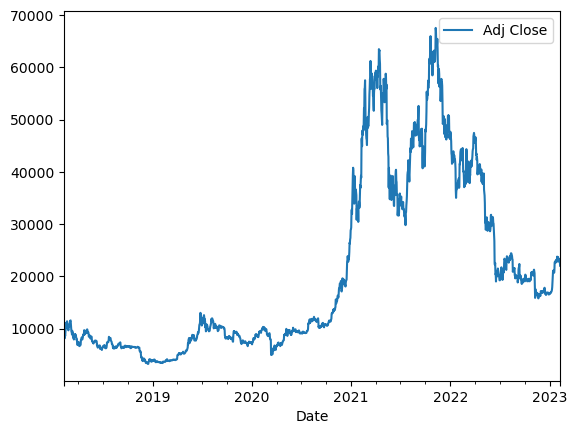

In [9]:
adj_close.plot()

In [10]:
ds = adj_close.values

In [11]:
ds

array([[ 8736.98046875],
       [ 8621.90039062],
       [ 8129.97021484],
       ...,
       [23264.29101562],
       [22939.3984375 ],
       [22036.7734375 ]])

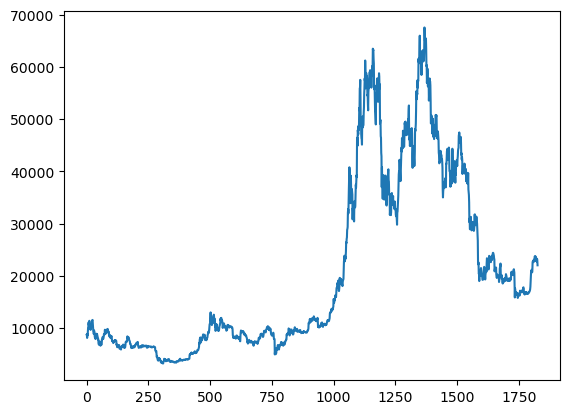

In [12]:
plt.plot(ds);

In [13]:
#standardize data
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [14]:
len(ds_scaled),len(ds)

(1827, 1827)

In [15]:
train_size = int(len(ds_scaled)*0.70)
test_size = len(ds_scaled)-train_size

In [16]:
train_size,test_size

(1278, 549)

In [17]:
ds_train,ds_test = ds_scaled[0:train_size,:],ds_scaled[train_size:len(ds_scaled),:1]

In [18]:
len(ds_train),len(ds_test)

(1278, 549)

In [19]:
#creating dataset in time series for LSTM
def create_ds(dataset,step):
    Xtrain,Ytrain = [],[]
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step),0]
        Xtrain.append(a)
        Ytrain.append(dataset[i+step,0])
    return np.array(Xtrain),np.array(Ytrain)

In [20]:
#taking 100 days price as one record for training
time_stamp = 100
x_train,y_train = create_ds(ds_train,time_stamp)
x_test,y_test = create_ds(ds_test,time_stamp)

In [21]:
x_train.shape,y_train.shape

((1177, 100), (1177,))

In [22]:
x_test.shape,y_test.shape

((448, 100), (448,))

In [23]:
#reshaping data to fit into LSTM model
x_train =x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test =x_test.reshape(x_test.shape[0],x_test.shape[1],1)


In [24]:
#creating LSTM model using keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [25]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer = 'adam')
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,batch_size=64)

Epoch 1/100
19/19 [==============================] - 17s 289ms/step - loss: 0.0213 - val_loss: 0.0137
Epoch 2/100
19/19 [==============================] - 3s 139ms/step - loss: 0.0031 - val_loss: 0.0026
Epoch 3/100
19/19 [==============================] - 4s 192ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 4/100
19/19 [==============================] - 3s 169ms/step - loss: 0.0017 - val_loss: 0.0030
Epoch 5/100
19/19 [==============================] - 2s 131ms/step - loss: 0.0017 - val_loss: 0.0034
Epoch 6/100
19/19 [==============================] - 3s 138ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 7/100
19/19 [==============================] - 3s 140ms/step - loss: 0.0014 - val_loss: 0.0030
Epoch 8/100
19/19 [==============================] - 3s 137ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 9/100
19/19 [==============================] - 3s 147ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 10/100
19/19 [==============================] - 3s 179ms/step - loss: 0.0012 - val_l

19/19 [==============================] - 3s 167ms/step - loss: 2.5526e-04 - val_loss: 5.1533e-04
Epoch 78/100
19/19 [==============================] - 3s 161ms/step - loss: 2.7395e-04 - val_loss: 5.5723e-04
Epoch 79/100
19/19 [==============================] - 3s 179ms/step - loss: 4.0291e-04 - val_loss: 5.7680e-04
Epoch 80/100
19/19 [==============================] - 3s 175ms/step - loss: 3.4160e-04 - val_loss: 0.0011
Epoch 81/100
19/19 [==============================] - 3s 167ms/step - loss: 3.2104e-04 - val_loss: 5.2098e-04
Epoch 82/100
19/19 [==============================] - 3s 173ms/step - loss: 2.9125e-04 - val_loss: 4.1936e-04
Epoch 83/100
19/19 [==============================] - 3s 175ms/step - loss: 2.5239e-04 - val_loss: 4.2184e-04
Epoch 84/100
19/19 [==============================] - 3s 166ms/step - loss: 2.5290e-04 - val_loss: 5.7463e-04
Epoch 85/100
19/19 [==============================] - 3s 169ms/step - loss: 2.5541e-04 - val_loss: 4.2773e-04
Epoch 86/100
19/19 [=======

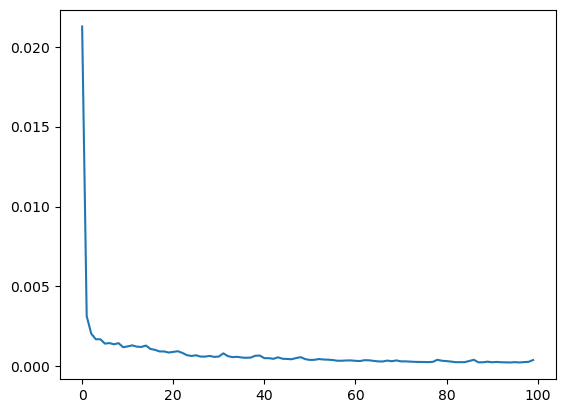

In [26]:
#plotting loss,it showsthat loss has decreased significantly and model trained well
loss = model.history.history['loss']
plt.plot(loss)

In [27]:
#Predicting on train and test data
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

14/14 [==============================] - 0s 34ms/step


In [28]:
#inverse transforn to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

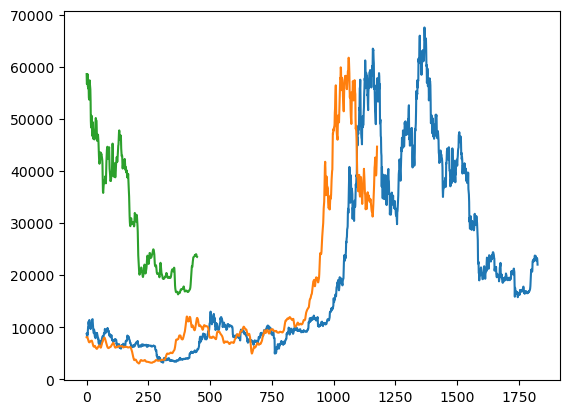

In [29]:
#comparing using visuals
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(train_predict)
plt.plot(test_predict)

In [30]:
type(train_predict)

numpy.ndarray

In [31]:
test = np.vstack((train_predict,test_predict))

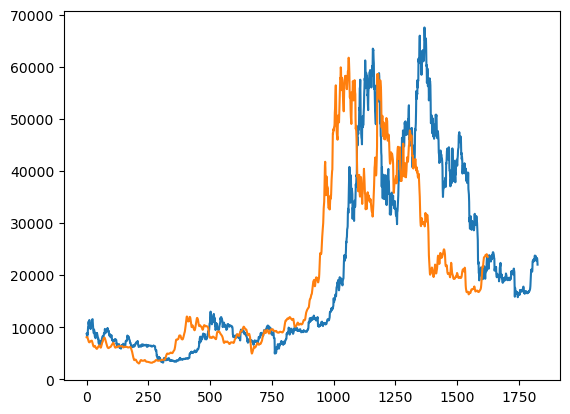

In [32]:
#combining the predicted data to creatye uniforn data visualization
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test)

In [33]:
len(ds_test)

549

In [34]:
#getting  the last 100 days records
fut_inp = ds_test[270:]

In [35]:
fut_inp = fut_inp.reshape(1,-1)

In [36]:
tmp_inp = list(fut_inp)

In [37]:
#creating list of the last 100 days
tmp_inp = tmp_inp[0].tolist()


In [38]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=(len(ds_test)-271)
i=0
while(i<30):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)
        

[[0.3102969527244568], [0.31049105525016785], [0.3135072588920593], [0.3175440728664398], [0.32191866636276245], [0.32646963000297546], [0.33118936419487], [0.3360990285873413], [0.3412213623523712], [0.3465765118598938], [0.35218125581741333], [0.35804691910743713], [0.3641800284385681], [0.37058138847351074], [0.3772473633289337], [0.3841705918312073], [0.3913412392139435], [0.39874768257141113], [0.40637725591659546], [0.41421693563461304], [0.422253280878067], [0.43047285079956055], [0.4388621747493744], [0.4474073648452759], [0.4560946524143219], [0.46490970253944397], [0.47383737564086914], [0.4828622341156006], [0.4919682741165161], [0.5011383295059204]]


In [39]:
len(ds_scaled)


1827

In [40]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,101)
plot_pred=np.arange(101,131)

In [41]:

ds_new = ds_scaled.tolist()

In [42]:
len(ds_new)


1827

In [43]:
#Creating final data for plotting
final_graph = normalizer.inverse_transform(ds_new).tolist()

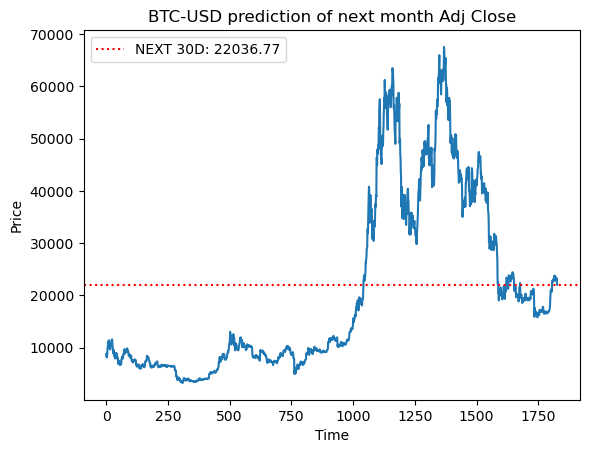

In [44]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month Adj Close".format(stock_symbol))
plt.axhline(y=final_graph[len(final_graph)-1], 
            color = 'red', linestyle = ':', 
            label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()

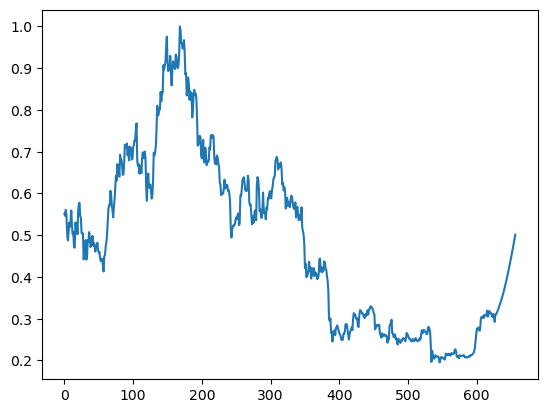

In [45]:
#Entends helps us to fill the missing value with approx value
ds_new.extend(lst_output)
plt.plot(ds_new[1200:])

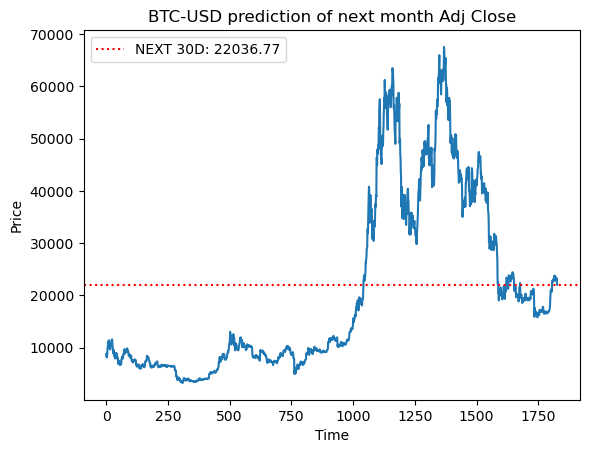

In [46]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month Adj Close".format(stock_symbol))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()